# 📘 Case-Based Reasoning pada Putusan Pidana Pencurian
**Tahapan 1–5 Lengkap**

## Tahap 1 – Membangun Case Base

In [1]:
import os
import re
import pandas as pd

def extract_no_perkara(text):
    match = re.search(r'Nomor\s*:?[\s\-]*([A-Z0-9\/\.\-]+)', text, re.IGNORECASE)
    return match.group(1).strip() if match else ''

def extract_tanggal(text):
    match = re.search(r'putusan.*?tanggal\s+(\d{1,2}\s+\w+\s+\d{4})', text, re.IGNORECASE)
    return match.group(1).strip() if match else ''

def extract_pasal(text):
    matches = re.findall(r'[Pp]asal\s+(\d+)(?:\s+([A-Za-z\.\/]+(?: [A-Za-z\.\/]+)*))?', text)
    return '; '.join({f"Pasal {m[0]} {m[1]}" if m[1] else f"Pasal {m[0]}" for m in matches}) if matches else ''

def extract_ringkasan(text, max_sentences=3):
    pattern = r'(menimbang bahwa.*?)(?:menetapkan|mengingat|memperhatikan|mengadili)'
    match = re.search(pattern, text.lower(), re.DOTALL)
    if match:
        sentences = re.split(r'(?<=[.!?]) +', match.group(1).strip())
        return ' '.join(sentences[:max_sentences])
    return ''

def extract_pihak(text):
    pihak = re.findall(r'(Terdakwa|Penggugat|Tergugat|Pemohon|Termohon)\s*:\s*(.*)', text, re.IGNORECASE)
    return '; '.join([f"{p[0].capitalize()}: {p[1].strip()}" for p in pihak]) if pihak else ''

# Proses semua file .txt
raw_path = 'data/raw'
os.makedirs('data/processed', exist_ok=True)

case_files = [f for f in os.listdir(raw_path) if f.endswith('.txt')]
cases = []

for fname in sorted(case_files):
    with open(os.path.join(raw_path, fname), 'r', encoding='utf-8') as file:
        text = file.read()
    cases.append({
        'case_id': fname.replace('.txt', ''),
        'no_perkara': extract_no_perkara(text),
        'tanggal': extract_tanggal(text),
        'pasal': extract_pasal(text),
        'ringkasan_fakta': extract_ringkasan(text),
        'pihak': extract_pihak(text),
        'text_full': text
    })

df = pd.DataFrame(cases)
df.to_csv('data/processed/cases.csv', index=False)
print("Tahap 1 selesai — file disimpan ke data/processed/cases.csv")


Tahap 1 selesai — file disimpan ke data/processed/cases.csv


## Tahap 2 – Representasi Kasus

In [4]:

import pandas as pd
from pathlib import Path

def extract_metadata(text):
    meta = {
        "no_perkara": re.search(r'Nomor\s*:?[\s\.]*(\S+)', text, re.IGNORECASE),
        "tanggal": re.search(r'\d{1,2}[-/\s]\d{1,2}[-/\s]\d{2,4}', text),
    }
    return {
        "no_perkara": meta["no_perkara"].group(1) if meta["no_perkara"] else "",
        "tanggal": meta["tanggal"].group(0) if meta["tanggal"] else ""
    }

def extract_pasal(text):
    match = re.search(r"Pasal\s+(\d+)\s+([a-zA-Z]*)\s*(KUHP)?", text)
    return match.group(0) if match else None

def extract_ringkasan(text):
    kalimat = text.strip().split(".")
    return kalimat[0] if kalimat else ""

cases = []
for fname in os.listdir("data/raw"):
    with open(f"data/raw/{fname}", "r", encoding="utf-8") as f:
        text = f.read()
    meta = extract_metadata(text)
    cases.append({
        "case_id": fname.replace(".txt", ""),
        "no_perkara": meta["no_perkara"],
        "tanggal": meta["tanggal"],
        "ringkasan_fakta": extract_ringkasan(text),
        "pasal": extract_pasal(text),
        "text_full": text
    })

df = pd.DataFrame(cases)
Path("data/processed").mkdir(parents=True, exist_ok=True)
df.to_csv("data/processed/cases.csv", index=False)
df.head()


,case_id,no_perkara,tanggal,ringkasan_fakta,pasal,text_full
0,case_001,10/Pid.B/2024/PN,,Direktori Putusan Mahkamah Agung Republik Indo...,Pasal 365 Ayat,Direktori Putusan Mahkamah Agung Republik Indo...
1,case_002,114/Pid.B/2025/PN,15-58-55,Direktori Putusan Mahkamah Agung Republik Indo...,Pasal 362 KUHP,Direktori Putusan Mahkamah Agung Republik Indo...
2,case_003,--/Pid.Sus-Anak/2024/PN,2/03/2024,Direktori Putusan Mahkamah Agung Republik Indo...,Pasal 363 Ayat,Direktori Putusan Mahkamah Agung Republik Indo...
3,case_004,130/Pid.B/2024/PN,,Direktori Putusan Mahkamah Agung Republik Indo...,Pasal 107 huruf,Direktori Putusan Mahkamah Agung Republik Indo...
4,case_005,135/Pid.C/2024/PN,,Direktori Putusan Mahkamah Agung Republik Indo...,Pasal 209 Ayat,Direktori Putusan Mahkamah Agung Republik Indo...


## Tahap 3 – Case Retrieval

In [5]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(df['text_full'].fillna(""))

def retrieve(query, k=5):
    query_vec = vectorizer.transform([query])
    sims = cosine_similarity(query_vec, X_tfidf)[0]
    top_k = sims.argsort()[::-1][:k]
    return list(df.iloc[top_k]['case_id'])

# Simpan beberapa query uji
import json
Path("data/eval").mkdir(parents=True, exist_ok=True)
queries = [
    {"query": "Terdakwa mengambil sepeda motor", "true_case_id": "case_001"},
    {"query": "Mencuri uang di toko", "true_case_id": "case_002"},
    {"query": "Merampas handphone dari korban", "true_case_id": "case_003"}
]
with open("data/eval/queries.json", "w", encoding="utf-8") as f:
    json.dump(queries, f, indent=2)


## Tahap 4 – Solution Reuse

In [6]:

# Tambahkan solusi dummy jika belum ada
if 'solusi' not in df.columns:
    solusi_dummy = [
        "Menjatuhkan pidana penjara 6 bulan",
        "Menjatuhkan pidana penjara 1 tahun",
        "Pidana 3 bulan dengan masa percobaan"
    ]
    df['solusi'] = (solusi_dummy * ((len(df) // len(solusi_dummy)) + 1))[:len(df)]
    df.to_csv("data/processed/cases.csv", index=False)

# Buat dictionary solusi
case_solutions = dict(zip(df['case_id'], df['solusi']))

def predict_outcome(query, k=5):
    top_k = retrieve(query, k)
    solusi_top = [case_solutions[c] for c in top_k if c in case_solutions]
    return max(set(solusi_top), key=solusi_top.count) if solusi_top else "Tidak ditemukan"

# Demo
for q in queries:
    hasil = predict_outcome(q["query"])
    print(f"Query: {q['query']}\nPrediksi: {hasil}\n")


Query: Terdakwa mengambil sepeda motor
Prediksi: Menjatuhkan pidana penjara 6 bulan

Query: Mencuri uang di toko
Prediksi: Pidana 3 bulan dengan masa percobaan

Query: Merampas handphone dari korban
Prediksi: Pidana 3 bulan dengan masa percobaan



## Tahap 5 – Evaluasi Model

📊 Evaluasi Prediksi Solusi:
                                      precision    recall  f1-score   support

  Menjatuhkan pidana penjara 1 tahun       0.00      0.00      0.00         1
  Menjatuhkan pidana penjara 6 bulan       1.00      1.00      1.00         1
Pidana 3 bulan dengan masa percobaan       0.50      1.00      0.67         1

                            accuracy                           0.67         3
                           macro avg       0.50      0.67      0.56         3
                        weighted avg       0.50      0.67      0.56         3



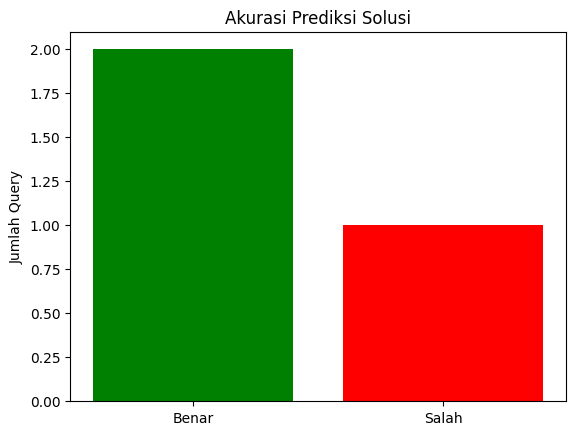

In [11]:

from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Tambah ground-truth
for q in queries:
    q['predicted'] = predict_outcome(q['query'])
    q['true_solution'] = case_solutions.get(q['true_case_id'], "Tidak diketahui")

# Evaluasi
y_true = [q['true_solution'] for q in queries]
y_pred = [q['predicted'] for q in queries]

report = classification_report(y_true, y_pred, zero_division=0, output_dict=True)
print("📊 Evaluasi Prediksi Solusi:")
print(classification_report(y_true, y_pred, zero_division=0))

# Simpan hasil
pd.DataFrame(report).transpose().to_csv("data/eval/prediction_metrics.csv")
with open("data/eval/queries.json", "w", encoding="utf-8") as f:
    json.dump(queries, f, indent=2)

# Visualisasi
benar = sum(1 for i in range(len(y_true)) if y_true[i] == y_pred[i])
salah = len(y_true) - benar

plt.bar(['Benar', 'Salah'], [benar, salah], color=['green', 'red'])
plt.title("Akurasi Prediksi Solusi")
plt.ylabel("Jumlah Query")
plt.show()
